To aid autoassociative recall (sparse recall using partial pattern), we need two components -
1. each pattern remembers a soft mask of the contribution of each 
element in activating it. For example, if an element varies a lot at high activation levels, that element should be masked out when determining activation. On the other hand, if an element has a very specific value every time the element has high activation, then that element is important and should be considered (masked-in).
2. Among the masked-in elements for a pattern, even a small subset (say 20%) almost perfect match should be able to activate the pattern. To find soft-perfect match -

mask weighted dim similarity ${s_i}$ will be high only if input value ${x_i}$ is similar to pattern value ${p_i}$ for that dim AND the pattern cares about that dim (i.e. has ~1 mask ${m_i}$)

${s_i = m_i * \lVert x_i, p_i \rVert}$

${s = {1 \over m} \sum s_i}$ is the total mean similarity across dims that the pattern cares about, where

${m = \sum m_i}$ is the soft version of the number of dims that the pattern cares about.



In [2]:
import math
import torch
import matplotlib.pyplot as plt
import pdb
import pandas as pd  
import seaborn as sns 
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from torchvision import datasets, transforms

%matplotlib inline
plt.style.use('classic')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


cpu


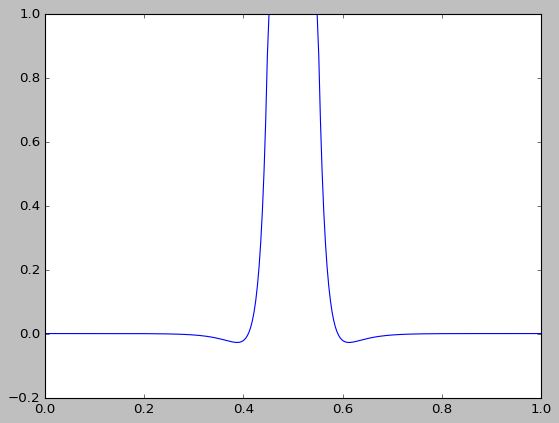

In [3]:
class HP:
  # dataset
  image_height = 8
  image_width = 8
  slice_stride = 1
  image_count_root = 150
  image_count = image_count_root * image_count_root

  # patterns
  pattern_count = 100
  pattern_size = image_height * image_width

  # similarity
  mask_contrast = 3

  # tophat formula derivation https://www.desmos.com/calculator/dnjp9agabt
  tophat_width_factor = 3.35  # w
  inhibition_factor = 0.4    # f
  inhibition_scale = 0.2     # i

  # training
  lr = 1

def tophat(x, patterns, winning_pattern):
  # winning_patther = W
  # pattern = p

  d1 = (x - patterns).abs()
  d2 = (x - winning_pattern).abs().clamp(min=0.0001)
  d = (d1 - d2).clamp(min=0)
  a = (-d * HP.tophat_width_factor / d2).mean(dim=-1)
  exc = torch.exp(a)
  inh = torch.exp(a * HP.inhibition_factor)

  sim = (exc - HP.inhibition_scale * inh) / (1.0 - HP.inhibition_scale)
  return sim

def show_tophat():
  x = torch.linspace(0.0, 1.0, 300)
  sim = tophat(torch.tensor([0.5]), x.unsqueeze(dim=-1), torch.tensor([0.55]))
  plt.plot(x, sim)
  plt.show()

show_tophat()

In [0]:
def add_gaussian_noise(tensor, mean=0., std=1.):
    t = tensor + torch.randn(tensor.size()).to(device) * std + mean
    t.to(device)
    return t

def show_image_grid(images, vmin=0, vmax=1):
  s = images.shape

  assert len(s) == 3
  image_grid_size = int(s[0] ** 0.5)
  if image_grid_size > 10:
    return
  fig, axs = plt.subplots(nrows=image_grid_size, ncols=image_grid_size, figsize=(image_grid_size * 0.5, image_grid_size * 0.5),
                        subplot_kw={'xticks': [], 'yticks': []})

  
  axs = axs.flat
  for i in np.arange(s[0]):
    axs[i].axis("off")
    axs[i].imshow(images[i].detach().cpu().numpy(), vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma, aspect='auto')
    
  fig.subplots_adjust(top=1, left=0, bottom=0, right=1, wspace=0.1, hspace=0.1)
  plt.show()


In [5]:
def load_mnist(train=True, batch_size=64):
  kwargs = {'num_workers': 1, 'pin_memory': True} if device=="cuda" else {}
  loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=train, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
  
  return loader

def convolve(image_width, image_height, kernel_width, kernel_height, stride):
  convolutions = []
  for x in range(0, image_width - kernel_width + 1, stride):
    for y in range(0, image_height - kernel_height + 1, stride):
      convolutions.append([y, x, y + kernel_height, x + kernel_width])

  return convolutions

def conv_slice(images, kernel_width, kernel_height, stride):
  image_count, image_height, image_width = images.shape
  convolutions = convolve(image_width, image_height, kernel_width, kernel_height, stride)
  slices = [images[i, c[0]:c[2], c[1]:c[3]] for i in range(image_count) for c in convolutions]

  slices = torch.stack(slices).float()
  slices = slices.view(slices.shape[0], -1).to(device)
  return slices

mnist = next(iter(load_mnist(train=False, batch_size=60)))[0].squeeze(dim=1)
original_dataset = conv_slice(mnist, kernel_width=HP.image_width, kernel_height=HP.image_height, stride=HP.slice_stride)
offset = 0
original_dataset = original_dataset[offset:offset+HP.image_count]
dataset = original_dataset
show_image_grid(dataset.view(-1, HP.image_height, HP.image_width))

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!





/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


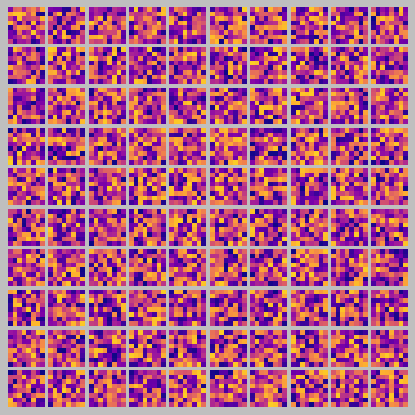

In [6]:
patterns = torch.rand((HP.pattern_count, HP.pattern_size)).to(device) * 0.9
pattern_lr = torch.ones((patterns.shape[0],)).to(device)
pattern_var = torch.ones_like(patterns).to(device) * 10   # start with high var indicating no specificity to any value

original_patterns = patterns.clone().to(device)
show_image_grid(patterns.view(-1, HP.image_height, HP.image_width))

In [0]:
def precision_weighted_distance(x, x_precision, patterns, pattern_var):
  mask = torch.exp(-pattern_var * HP.mask_contrast) # *3 so that var of 1 gives low enough mask value ~0.5. Thus mask range [0.5,1]
  dist_i = (x - patterns).abs()
  di = (dist_i ** 2) * mask  # distance weighted by importance
  if x_precision is not None:
    di = di * x_precision
  dist = di.sum(dim=-1) / mask.sum(dim=-1) # dividing by mask sum ~= count of # of dims the pattern cares about
  return dist, dist_i

def similarity(x, x_precision, patterns, pattern_var):
  # Formula derivation https://www.desmos.com/calculator/iokn9kyuaq
  # print("x", x)
  # print("patterns", patterns)
  dist, dist_i = precision_weighted_distance(x, x_precision, patterns, pattern_var)
  # print("dist", dist)
  winner_index = dist.min(dim=0)[1]
  # print("winner_index", winner_index)

  winning_pattern = patterns[winner_index]
  # print("winning_pattern", winning_pattern)

  sim = tophat(x, patterns, winning_pattern)

  # print("sim", sim)

  return sim, winner_index, dist, dist_i

def autoassociative_recall(x, x_precision, patterns, pattern_var, pattern_lr):
  dist, _ = precision_weighted_distance(x, x_precision, patterns, pattern_var)
  sim = torch.exp(-dist*10) * (1.0 - pattern_lr)
  y = ((sim.unsqueeze(-1) * patterns) / sim.sum(-1)).sum(dim=0)
  # y = ((y - 0.5) * 1.1) + 0.5
  return y

def predict(dataset, dataset_precision, patterns, pattern_var, pattern_lr):
  loss = 0.0
  output = []
  # pdb.set_trace()

  for i in range(dataset.shape[0]):
    x = dataset[i]
    if dataset_precision is not None:
      x_precision = dataset_precision[i]
    else:
      x_precision = None
    y = autoassociative_recall(x, x_precision, patterns, pattern_var, pattern_lr)
    output.append(y)
    loss += torch.dist(x, y)

  output = torch.stack(output)
  # plot_patterns(output, pattern_lr=None, dataset=original_dataset, voronoi=False, annotate=False, figsize=(12,12))
  print("loss", loss)
  return output, loss

# output, loss = predict(original_dataset, patterns, pattern_var, pattern_lr)

In [0]:
def run_dataset(dataset, patterns, pattern_lr, pattern_var):
  # print("pattern_var", pattern_var)
  for x in dataset:
    # print("-------")
    sim, winner_index, dist, dist_i = similarity(x=x, x_precision=None, patterns=patterns, pattern_var=pattern_var)
    # winning_pattern = patterns[winner_index]
    # plt.imshow(x.view(HP.image_height, HP.image_width), interpolation='none', cmap=plt.cm.plasma, aspect='auto')
    # plt.show()
    # print("winner index", winner_index)
    # print("winner distance", dist[winner_index])

    # introduce new pattern for x if no pattern is close enough
    # if dist[winner_index] > 0.05:
    #   loser_index = pattern_lr.max(dim=0)[1]
    #   # print("loser_index", loser_index)
    #   patterns[loser_index] = x
    #   pattern_lr[loser_index] = 0.99
    #   sim, winner_index, dist, dist_i = similarity(x=x, x_precision=None, patterns=patterns, pattern_var=pattern_var)

    sim = sim.unsqueeze(-1)
    # print("dist[winner_index]", dist[winner_index] * 100)
    pattern_lr[winner_index] = 0.9 * pattern_lr[winner_index] + 0.1 * (1.0 - torch.exp(-dist[winner_index]))
    pattern_var[winner_index] = 0.9 * pattern_var[winner_index] + 0.1 * dist_i[winner_index]
    # if winner_index == 0:
    #   print("dist_i[winner_index]", dist_i[winner_index])
    #   print("pattern_var[winner_index]", pattern_var[winner_index])

    # print("x", x)
    # print("(x - patterns)", (x - patterns))
    # print("sim", sim)
    delta = (x - patterns) * sim * HP.lr * pattern_lr.unsqueeze(-1)
    # print("delta", delta)
    patterns = patterns + delta
    # show_image_grid(patterns.view(-1, HP.image_height, HP.image_width))
    # winning_pattern = patterns[winner_index]
    # plt.imshow(winning_pattern.view(HP.image_height, HP.image_width), interpolation='none', cmap=plt.cm.plasma, aspect='auto')
    # plt.show()


  patterns.clamp_(0, 1)
  pattern_lr.clamp(0, 1)
  # print("patterns", patterns)
  # print("pattern_lr", pattern_lr)
  return patterns, pattern_lr, pattern_var

def run(patterns=original_patterns*0.1, epochs=4, noise=0.0):
  pattern_lr = torch.ones((patterns.shape[0],)).to(device) * 1.0
  pattern_var = torch.ones_like(patterns).to(device) * 1.0
  dataset_precision = None

  predict(original_dataset, dataset_precision, patterns, pattern_var, pattern_lr)
  for i in range(epochs):
    dataset = add_gaussian_noise(original_dataset, std=noise)

    # # increase contrast
    # dataset = 2.0 * (dataset - 0.5) + 0.5

    # if (i+1) % int(epochs / 4) == 0:
    #   print("Iteration ", i)
    #   show_image_grid(patterns.view(-1, HP.image_height, HP.image_width))
    #   show_image_grid(torch.exp(-pattern_var.view(-1, HP.image_height, HP.image_width) * HP.mask_contrast))
    patterns, pattern_lr, pattern_var = run_dataset(dataset, patterns, pattern_lr, pattern_var)
    predict(original_dataset, dataset_precision, patterns, pattern_var, pattern_lr)

  show_image_grid(patterns.view(-1, HP.image_height, HP.image_width))
  show_image_grid(torch.exp(-pattern_var.view(-1, HP.image_height, HP.image_width) * HP.mask_contrast))
  show_image_grid(dataset.view(-1, HP.image_height, HP.image_width))
  return patterns, pattern_lr, pattern_var

loss tensor(nan)
loss tensor(47322.7891)
loss tensor(47768.3945)
loss tensor(47536.9102)
loss tensor(47845.1406)
loss tensor(47535.5430)


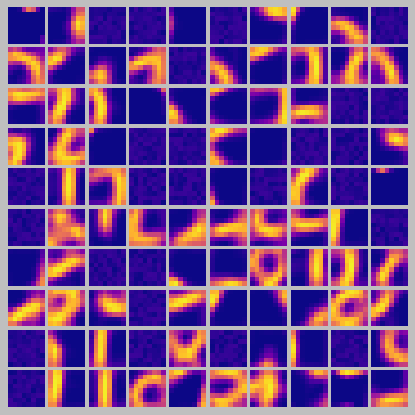

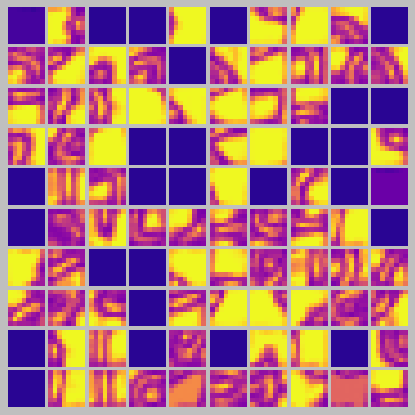

In [10]:
HP.tophat_width_factor = 50
patterns, pattern_lr, pattern_var = run(epochs=5)

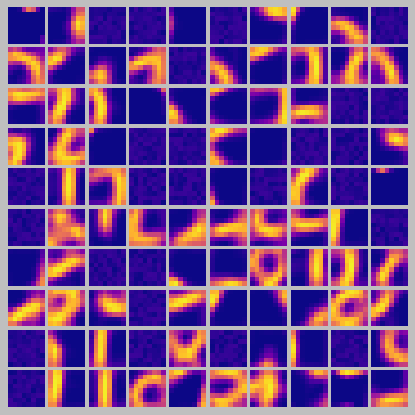

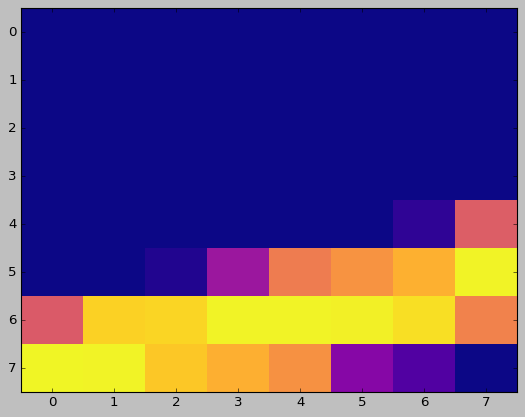

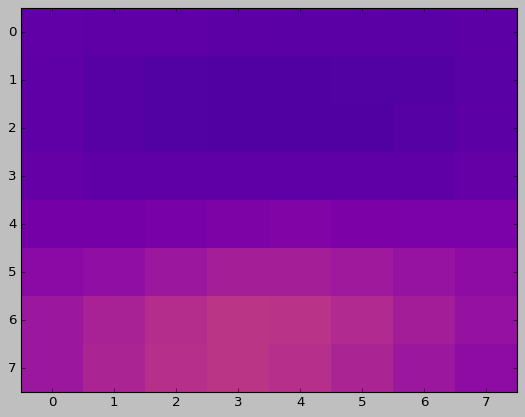

tensor([0.0291, 0.0877, 0.0000, 0.0000, 0.1064, 0.0000, 0.0328, 0.0859, 0.1667,
        0.0000, 0.0189, 0.0276, 0.2744, 0.0195, 0.0000, 0.2160, 0.0389, 0.0635,
        0.1576, 0.0951, 0.0104, 0.0148, 0.0463, 0.1091, 0.1933, 0.1106, 0.1184,
        0.2635, 0.0000, 0.0000, 0.0557, 0.0815, 0.1087, 0.0000, 0.0000, 0.0706,
        0.1263, 0.0000, 0.0000, 0.0240, 0.0000, 0.0458, 0.0416, 0.0000, 0.0000,
        0.1668, 0.0000, 0.0177, 0.0000, 0.0494, 0.0000, 0.0621, 0.0357, 0.1958,
        0.3713, 0.0398, 0.0252, 0.0094, 0.0440, 0.0000, 0.1553, 0.0076, 0.0000,
        0.0000, 0.2620, 0.4821, 0.0910, 0.0517, 0.0617, 0.0628, 0.0918, 0.0153,
        0.0152, 0.0000, 0.0058, 0.0522, 0.0826, 0.3738, 0.0269, 0.0210, 0.0000,
        0.0888, 0.0575, 0.0000, 0.0293, 0.0000, 0.3266, 0.0895, 0.0000, 0.0886,
        0.0000, 0.0285, 0.0549, 0.0421, 0.0658, 0.0919, 0.0169, 0.0969, 0.0696,
        0.7988])
winner_index tensor(99)


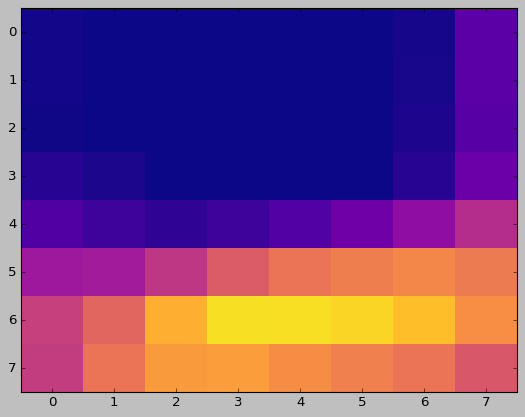

In [11]:
show_image_grid(patterns.view(-1, HP.image_height, HP.image_width))

x = dataset[150]
result = autoassociative_recall(x, None, patterns, pattern_var, pattern_lr)

plt.imshow(x.view(HP.image_height, HP.image_width), vmin=0, vmax=1, interpolation='none', cmap=plt.cm.plasma, aspect='auto')
plt.show()
plt.imshow(result.view(HP.image_height, HP.image_width), vmin=0, vmax=1, interpolation='none', cmap=plt.cm.plasma, aspect='auto')
plt.show()

dist, _ = precision_weighted_distance(x, None, patterns, pattern_var)
sim = torch.exp(-dist*10) * (1.0 - pattern_lr)
print(sim)
winner_index = dist.min(dim=0)[1]
print("winner_index", winner_index)
winning_pattern = patterns[winner_index]
plt.imshow(winning_pattern.view(HP.image_height, HP.image_width), vmin=0, vmax=1, interpolation='none', cmap=plt.cm.plasma, aspect='auto')
plt.show()


In [10]:
patterns[12]

tensor([1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        0.4999, 0.0000, 0.0000, 0.0000, 0.0000, 0.9571, 1.0000, 1.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.5812, 1.0000, 0.6793, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.7464, 0.7564, 0.0000, 0.0000, 0.0000,
        0.0000])